In [164]:
# import packages
import numpy as np
from aicsimageio import AICSImage
import torch as ch
from tqdm import tqdm
from os import path
import argparse
from distutils.util import strtobool
import os
import ast
import pandas as pd
from cellpose import models
import matplotlib.pyplot as plt
import seaborn as sns


from confocalQuant.segmentation import load_3D, int_to_float, run_med_filter, bgrnd_subtract, get_anisotropy, do_inference,  sigmoid, gamma_correct_image, get_czi_files, toggle_filters
from confocalQuant.quantification import get_all_expectations
from confocalQuant.image import save_mean_proj
from confocalQuant.qc import get_metadata, return_non_unique_indices, print_metadata, return_channel_moments_per_im, get_day_and_time, plot_by, plot_hist, impose_segmentation_all
from confocalQuant.plotting import return_results

In [165]:
def extract_sbatch_parameters(file_path):
    parameters = {}

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()

            # Ignore comments
            if line.startswith("#"):
                continue

            # Extract key-value pairs or parameters in list form
            parts = line.split()
            if len(parts) >= 2:
                key, *values = parts
                if '\\' in values:
                    # Handle parameters in the form of "--key value1 value2 \"
                    values = values[:values.index('\\')]
                parameters[key] = values
            elif len(parts) == 1:
                # Handle parameters in list form
                parameters.setdefault('list_parameters', []).extend(parts)

    return parameters

def return_results(path_to_sbatch_file, prefix):
    # get data and params
    params = extract_sbatch_parameters(path_to_sbatch_file)
    folder = params['--folder'][0][1:-1]
    NZi = int(params['--NZi'][0])
    xi_per_job = int(params['--xi_per_job'][0])
    yi_per_job = int(params['--yi_per_job'][0])
    cells_per_job = int(params['--cells_per_job'][0])
    Ncells = int(params['--Ncells'][0])
    Njobs = int(params['--Njobs'][0])
    channels = [int(x) for x in params['--channels']]
    mode = 'r'
    zi_per_job = int(params['--zi_per_job'][0])

    all_mat = np.lib.format.open_memmap(path.join(prefix + folder, 'mat.npy'), shape=(NZi, xi_per_job, yi_per_job, len(channels)), dtype=float, mode=mode)
    all_masks = np.lib.format.open_memmap(path.join(prefix + folder, 'masks.npy'), shape=(NZi, xi_per_job, yi_per_job), dtype='uint16', mode=mode)
    Nzi_per_job = np.lib.format.open_memmap(path.join(prefix + folder, 'Nzi_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)
    randID = np.lib.format.open_memmap(path.join(prefix + folder, 'randomID_per_job.npy'), shape=(Njobs,1), dtype=int, mode=mode)

    probs = np.lib.format.open_memmap(path.join(prefix + folder, 'probs.npy'), shape=(Njobs,1), dtype=float, mode=mode)
    
    return all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID

import numba as nb
@nb.njit(parallel=True)
def get_expectations(M_unique, masks_sele, probs_sele, vals_sele, E, V, N):
    for M in nb.prange(M_unique):
        index = masks_sele==M
        temp_probs = probs_sele[index]
        temp_vals = vals_sele[index]

        #E_uniform[M] = np.mean(temp_vals)
        P = temp_probs/np.sum(temp_probs)
        E[M] = np.dot(temp_vals, P)
        V[M] = np.dot((np.power((temp_vals-E[M]),2)), P)/E[M]
        N[M] = np.sum(index)
        
def plot_hist(path, channel, nbins, scale_log, alpha, color, density):
    img = AICSImage(path)
    T = img.data[0,channel,:,:,:].ravel()
    T[T==0] = 1
    plt.hist(np.log(int_to_float(T)),nbins, alpha=alpha, color=color, density=density)
    None
    
    
   
def plot_treatments(df, x, line, colors, lognormal, binwidth,lab_height, grp='well'):
    sns.set(rc={'figure.figsize':(20,7)})
    sns.set_style("whitegrid")
    df_temp = df[df['line']==line]
    


    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(3,5, sharex=True, gridspec_kw={"height_ratios": (1,.25,.5)})

    for i,t in enumerate(np.unique(df['treatment'])[:-1]):
        index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
        # compute pvalue 
        text = compute_nested_anova(df_temp[index], x, 'treatment', grp)
        sns.histplot(data=df_temp[index], x=x, ax=ax[0,i], hue='treatment', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
        
        ax[0,i].text(x=np.mean(df_temp[index][x]), y=lab_height, s=text, fontsize=12, color='black')
        
        #ax[0,i].legend(loc='lower left', bbox_to_anchor=(0, 1))
        sns.boxplot(data=df_temp[index], x=x, y='treatment',orient="h", ax=ax[1,i], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
        sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[2,i], width=.8, dodge=False, hue = 'treatment', palette = colors)#, order =(order))#, palette = colors)
        ax[2,i].get_legend().remove()
        ax[1,i].axes.get_yaxis().set_visible(False)




import czifile
import xml.etree.ElementTree as ET

def get_metadata(czi_file_path):
    # Open the CZI file
    with czifile.CziFile(czi_file_path) as czi:
        # Read the metadata from the CZI file
        metadata = czi.metadata()
        img = AICSImage(czi_file_path)
        root = ET.fromstring(metadata)

        RI = root.find(".//RefractiveIndex").text
        PinholeSizeAiry = root.find(".//PinholeSizeAiry").text    
        SizeX = root.find(".//SizeX").text
        SizeY = root.find(".//SizeY").text
        SizeZ = root.find(".//SizeZ").text
        SizeC = root.find(".//SizeC").text

        fluor = [x.text for x in root.findall('.//Fluor')]
        exwave = [x.text for x in root.findall('.//ExcitationWavelength')]
        emwave = [x.text for x in root.findall('.//EmissionWavelength')]
        #pinhole_diam = [x.text for x in root.findall('.//Position')]
        
        parameter_id = "MTBLSMPinholeDiameter"
        pinhole_diam = [x.text for x in root.findall(f'.//ParameterCollection[@Id="{parameter_id}"]/Position')]


        NA = [x.text for x in root.findall('.//NumericalAperture')]
        bits = [x.text for x in root.findall('.//BitsPerPixel')]
        time = [x.text for x in root.findall('.//CreationDate')]
        intensity = [x.text for x in root.findall('.//Intensity')]

        DigitalGain = [x.text for x in root.findall('.//DigitalGain')]
        DigitalOffset = [x.text for x in root.findall('.//DigitalOffset')]

        TotalMagnification = [x.text for x in root.findall('.//TotalMagnification')]
        TotalAperture = [x.text for x in root.findall('.//TotalAperture')]

        LaserEnableTime = [x.text for x in root.findall('.//LaserEnableTime')]
        #ZStackSliceIndex = [x.text for x in root.findall('.//LineStep')]

        dictionary2 = dict({'RI': RI,
              'PinholeSizeAiry': PinholeSizeAiry,
              'SizeX': SizeX, 
              'SizeY': SizeY,
              'SizeZ': SizeZ,
              'SizeC': SizeC,
              'Fluor': fluor,
              'ExcitationWavelength': exwave,
              'EmissionWavelength': emwave,
              'MTBLSMPinholeDiameter': pinhole_diam,
              'NumericalAperture': NA,
              'BitsPerPixel': bits,
              'AcquisitionDateAndTime': time,
              'Intensity': intensity,
              'DigitalGain': DigitalGain,
              'DigitalOffset': DigitalOffset,
              'TotalMagnification': TotalMagnification,
              'TotalAperture': TotalAperture,
              'LaserEnableTime': LaserEnableTime,
              'pixelsize': img.physical_pixel_sizes})
        
        return dictionary2

In [166]:
from confocalQuant.plotting import get_out_files, is_string_present

# Do all the SBATCH files for the IDs we care about say done?

out_files = get_out_files('./outs/10252023_SREBP2_matchedcohort_out//')
out_files = np.array(out_files)[np.argsort([int(x.split('_')[1].split('.')[0]) for x in out_files])]
res = []
for file in out_files:
    res.append((file, is_string_present('./outs/10252023_SREBP2_matchedcohort_out/'+file, 'done')))
    
res

[('slurm-24579308_0.out', True),
 ('slurm-24579308_1.out', True),
 ('slurm-24579308_2.out', True),
 ('slurm-24579308_3.out', True),
 ('slurm-24579308_4.out', True),
 ('slurm-24579308_5.out', True),
 ('slurm-24579308_6.out', True),
 ('slurm-24579308_7.out', True),
 ('slurm-24579308_8.out', True),
 ('slurm-24579308_9.out', True),
 ('slurm-24579308_10.out', True),
 ('slurm-24579308_11.out', True),
 ('slurm-24579308_12.out', True),
 ('slurm-24579308_13.out', True),
 ('slurm-24579308_14.out', True),
 ('slurm-24579308_15.out', True),
 ('slurm-24579308_16.out', True),
 ('slurm-24579308_17.out', True),
 ('slurm-24579308_18.out', True),
 ('slurm-24579308_19.out', True),
 ('slurm-24579308_20.out', True),
 ('slurm-24579308_21.out', True),
 ('slurm-24579308_22.out', True),
 ('slurm-24579308_23.out', True),
 ('slurm-24579308_24.out', True),
 ('slurm-24579308_25.out', True),
 ('slurm-24579308_26.out', True),
 ('slurm-24579308_27.out', True),
 ('slurm-24579308_28.out', True),
 ('slurm-24579308_29.out

In [167]:
# do QC checks - return metadata for which there are image to image differences
parent = './data/10252023_SREBP2_matchedcohort/////////////'
files = get_czi_files(parent)

In [168]:
dictionaries = [get_metadata(parent+x) for x in files]
df = pd.DataFrame(dictionaries)
print('The following metadata variables are NOT consistent across images:')
temp = return_non_unique_indices(df)

The following metadata variables are NOT consistent across images:
PinholeSizeAiry
SizeZ
AcquisitionDateAndTime


In [169]:
# check datatype
img = AICSImage(parent+files[0])
img.data.dtype

dtype('uint8')

In [7]:
img.physical_pixel_sizes

PhysicalPixelSizes(Z=1.0, Y=0.41513291204989755, X=0.41513291204989755)

In [22]:
# get channel means & stds
means, stds, out_percent_clipped = return_channel_moments_per_im(files, parent, 3, (2**16)-1)

100%|██████████| 84/84 [02:19<00:00,  1.67s/it]


In [ ]:
# rerun with the 22 diam pixel

In [170]:
meta = pd.read_csv(parent + 'temp.csv')


In [26]:
meta.head()

,ID,Group
0,10101327con_1,CON
1,10101327con_2,CON
2,10101327con_3,CON
3,10101327con_4,CON
4,10101327con_5,CON


In [171]:
# get line / treatment info
meta = pd.read_csv(parent + 'temp.csv')
dictionary = dict(zip(meta['ID'], meta['Group']))
meta = pd.DataFrame(np.concatenate((np.array(files).reshape(-1,1),np.array([dictionary[x.split('.')[0]] for x in files]).reshape(-1,1)), axis=1))
meta.columns = ['filename', 'grp']
meta['projid'] = [x.split('_')[0] for x in meta['filename']]

In [172]:
meta.head()

,filename,grp,projid
0,10101327con_1.czi,CON,10101327con
1,10101327con_2.czi,CON,10101327con
2,10101327con_3.czi,CON,10101327con
3,10101327con_4.czi,CON,10101327con
4,10101327con_5.czi,CON,10101327con


In [173]:
lines = np.array(meta['grp'])

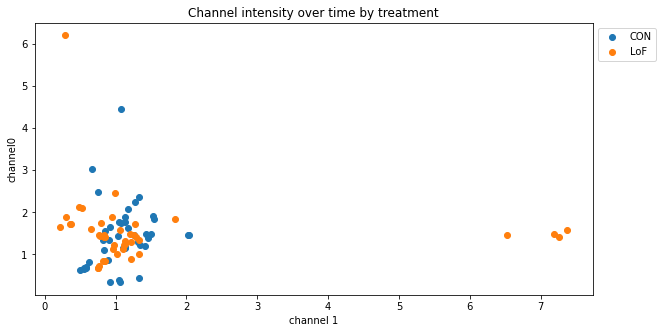

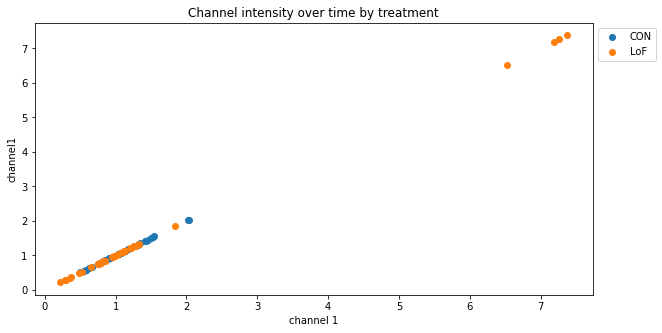

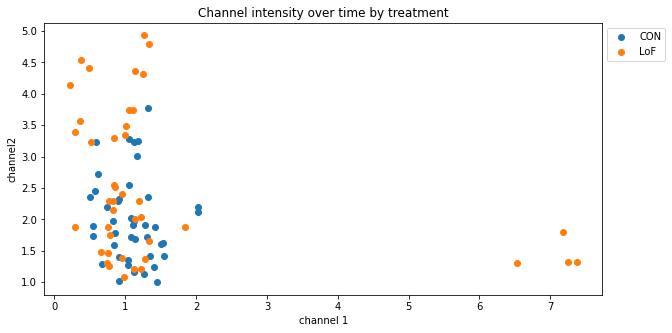

In [75]:
N = 3
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(lines, means[:,1], means[:,x].reshape(-1), xlab='channel 1', ylab='channel' + str(x))
    plt.title('Channel intensity over time by treatment')
    

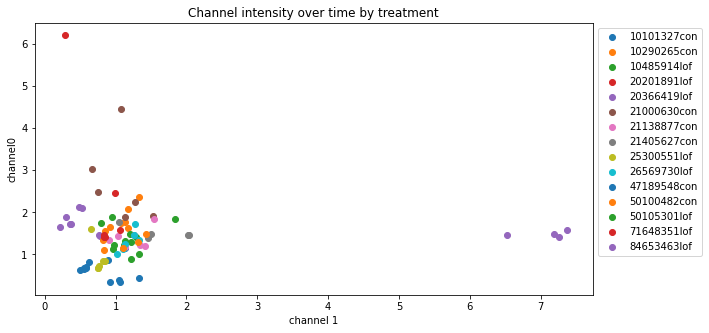

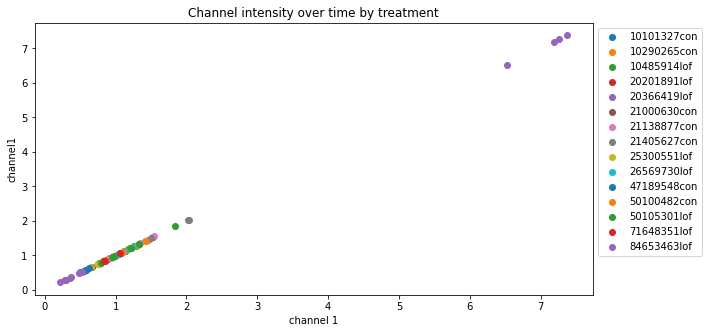

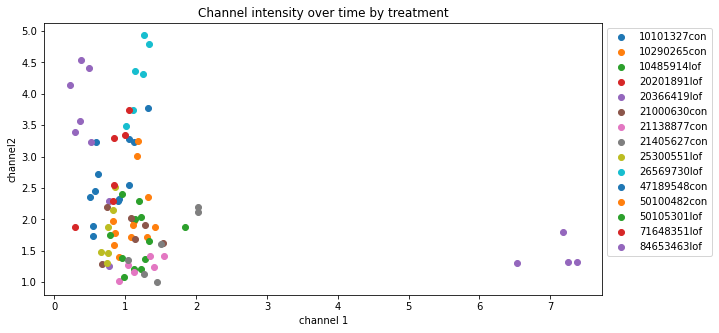

In [89]:
projid = np.array(meta['projid'])
N = 3
for x in range(N):
    plt.figure(figsize=(10,5))
    plot_by(projid, means[:,1], means[:,x].reshape(-1), xlab='channel 1', ylab='channel' + str(x))
    plt.title('Channel intensity over time by treatment')
    

In [174]:
day, time = get_day_and_time(df)

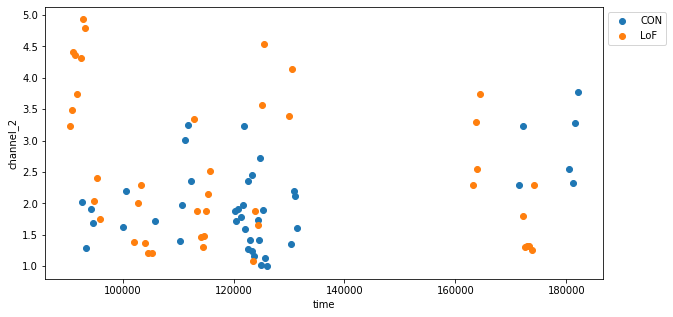

In [84]:
# plot dists by condition

day, time = get_day_and_time(df)
N = 3
plt.figure(figsize=(10,5))
plot_by(lines, time, means[:,2].reshape(-1), xlab='time', ylab='channel_2')

    

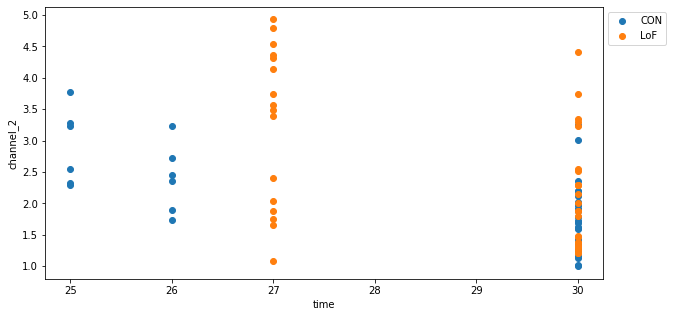

In [88]:
# plot dists by condition
day, time = get_day_and_time(df)
N = 3
plt.figure(figsize=(10,5))
plot_by(lines, day, means[:,2].reshape(-1), xlab='time', ylab='channel_2')

    

In [175]:
# toggle segmentations
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job  = return_results('./outs/10252023_SREBP2_matchedcohort_out/run_jobs_srebp.sbatch', '')

In [176]:
# toggle segmentation
val = 1
out_seg = []
for i in tqdm(range(len(files))): #
    out_seg.append(impose_segmentation_all(i, zi_per_job, Nzi_per_job, all_mat, all_masks, val))

100%|██████████| 84/84 [02:58<00:00,  2.12s/it]


In [177]:
channels = [0,1,2] #### ADD CUSTOM CHANNELS ####

toggle_filters(files, parent, [0,1,2], out_seg) #index1], files[index2]


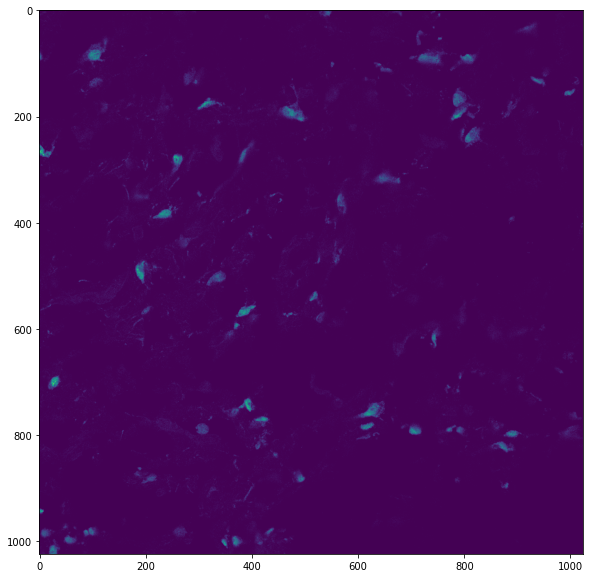

In [107]:
plt.figure(figsize=(10,10))
plt.imshow(all_mat[10,:,:,1])

In [ ]:
# hide soma masks that are not also in a DAPI mask

In [178]:
channels = [0,1,2]
channel_names = ['SREBP', 'NeuN', 'DAPI']
resE = []
resV = []
resN = []

for ID in tqdm(range(len(files))):
    start = ID*zi_per_job
    end = start + Nzi_per_job[ID][0]
    
    probs_sele = probs[start:end].ravel()
    masks_sele = all_masks[start:end].ravel()
    out_float_sele = all_mat[start:end]
    
    M_unique = np.unique(masks_sele)
    NM = len(M_unique)
    
    outputs_E = np.empty((NM, len(channels)))
    outputs_V = np.empty((NM, len(channels)))
    outputs_N = np.empty((NM, len(channels)))

    E = np.empty(NM)
    V = np.empty(NM)
    N = np.empty(NM)
    
    for C in channels:
        vals_sele = out_float_sele[:,:,:,C].ravel()
        get_expectations(NM, masks_sele, probs_sele, vals_sele, E, V, N)
        outputs_E[:,C] = E
        outputs_V[:,C] = V
        outputs_N[:,C] = N

    df_E = pd.DataFrame(outputs_E[1:])
    df_E.columns = ['channel_' + str(i) for i in channel_names]
    df_E['ID'] = ID
    df_E['file'] = files[ID]
    df_E['grp'] = lines[ID]
    df_E['projid'] = projid[ID]

    df_V = pd.DataFrame(outputs_V[1:])
    df_V.columns = ['channel_' + str(i) for i in channel_names]
    df_V['ID'] = ID
    df_V['file'] = files[ID]
    df_V['grp'] = lines[ID]
    df_V['projid'] = projid[ID]
    
    df_N = pd.DataFrame(outputs_N[1:])
    
    resE.append(df_E)
    resV.append(df_V)
    resN.append(df_N)

100%|██████████| 84/84 [04:13<00:00,  3.02s/it]


In [ ]:
# update size here because different z

In [179]:
# concatenate the results

resE = pd.concat(resE)
resE.index = range(resE.shape[0])

resV = pd.concat(resV)
resV.index = range(resV.shape[0])

resN = pd.concat(resN)
resN.index = range(resN.shape[0])
resE['size'] = resN[0]

In [180]:
resE

,channel_SREBP,channel_NeuN,channel_DAPI,ID,file,grp,projid,size
0,0.041824,0.093428,0.069044,0,10101327con_1.czi,CON,10101327con,8993.0
1,0.052477,0.129880,0.060316,0,10101327con_1.czi,CON,10101327con,10690.0
2,0.023714,0.109429,0.086205,0,10101327con_1.czi,CON,10101327con,1897.0
3,0.034601,0.124562,0.094686,0,10101327con_1.czi,CON,10101327con,1223.0
4,0.041843,0.122482,0.144319,0,10101327con_1.czi,CON,10101327con,2451.0
...,...,...,...,...,...,...,...,...
14518,0.022593,0.087106,0.110940,83,84653463lof_6.czi,LoF,84653463lof,794.0
14519,0.044610,0.075157,0.223526,83,84653463lof_6.czi,LoF,84653463lof,3084.0
14520,0.072703,0.122825,0.130516,83,84653463lof_6.czi,LoF,84653463lof,879.0
14521,0.026495,0.046458,0.013141,83,84653463lof_6.czi,LoF,84653463lof,837.0


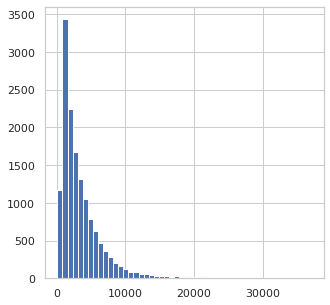

In [183]:
plt.figure(figsize=(5,5))
plt.hist((resE['size']),50)

None

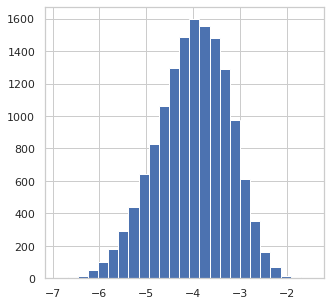

In [184]:
plt.figure(figsize=(5,5))
plt.hist(np.log2(resE['channel_NeuN']),25)

None

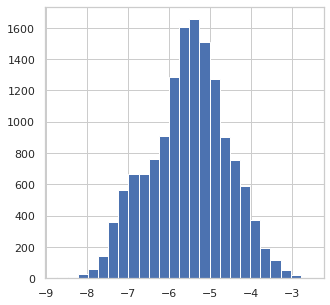

In [185]:
plt.figure(figsize=(5,5))
plt.hist(np.log2(resE['channel_SREBP']),25)

None

In [186]:
from sklearn.mixture import GaussianMixture

# Extract the first two columns for GMM
gmm_data = resE[['channel_DAPI']]

# Define the range of components to try
n_components_range = range(1, 6)

# Fit GMMs with different numbers of components
bics = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(gmm_data)
    bics.append(gmm.bic(gmm_data))

# Find the optimal number of components (lowest BIC)
optimal_n_components = n_components_range[bics.index(min(bics))]

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=optimal_n_components, random_state=5, max_iter=1000)
gmm.fit(gmm_data)

# Predict the labels
labels = gmm.predict(gmm_data)
gmm_data['gmm_label'] = labels

# Add the labels to the DataFrame
resE['gmm_label'] = labels


/state/partition1/slurm_tmp/24579079.0.0/ipykernel_486687/2530637508.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmm_data['gmm_label'] = labels


<Axes: xlabel='channel_DAPI', ylabel='Count'>

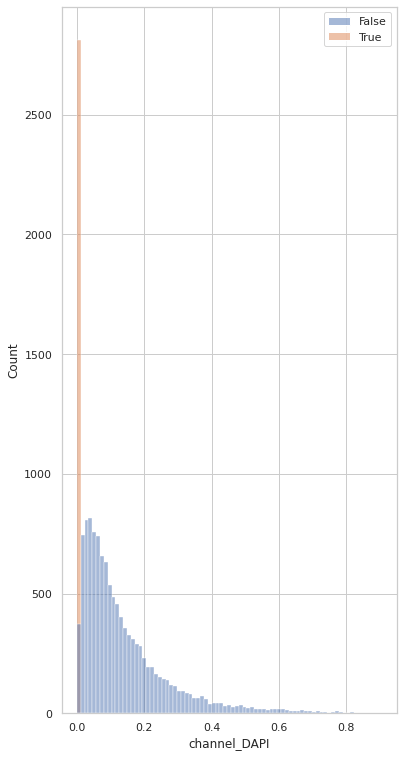

In [189]:
sns.histplot(data=resE, x='channel_DAPI', hue = labels==2)


<Axes: xlabel='log_DAPI', ylabel='log_NeuN'>

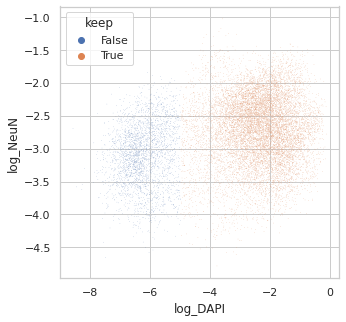

In [190]:
resE['log_DAPI'] = np.log(resE['channel_DAPI'])
resE['log_NeuN'] = np.log(resE['channel_NeuN'])
resE['keep'] = resE['gmm_label']!=2
plt.figure(figsize=(5,5))
sns.scatterplot(data=resE, x=('log_DAPI'), y = ('log_NeuN'), hue = 'keep', s=.2)

In [191]:
np.unique(resE['keep'], return_counts=True)

(array([False,  True]), array([ 2810, 11713]))

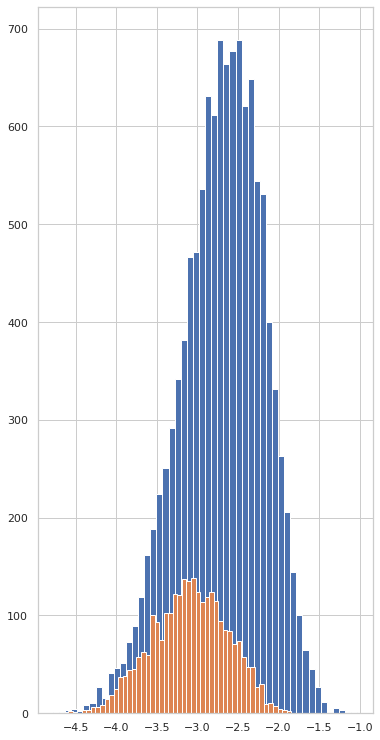

In [192]:
plt.hist(np.log(resE['channel_NeuN'][resE['keep']]), 50)
plt.hist(np.log(resE['channel_NeuN'][np.invert(resE['keep'])]), 50)
None

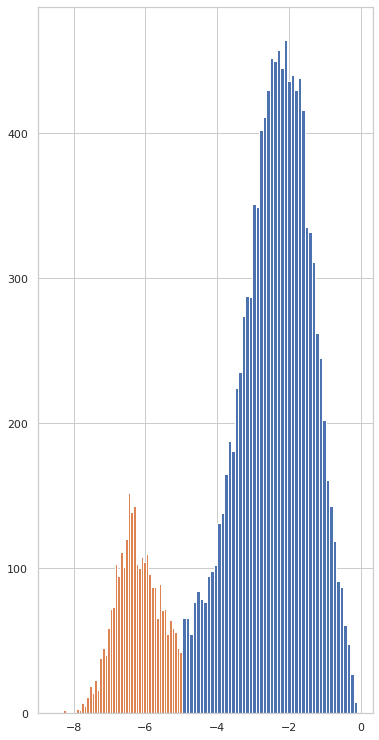

In [193]:
plt.hist(np.log(resE['channel_DAPI'][resE['keep']]), 50)
plt.hist(np.log(resE['channel_DAPI'][np.invert(resE['keep'])]), 50)
None

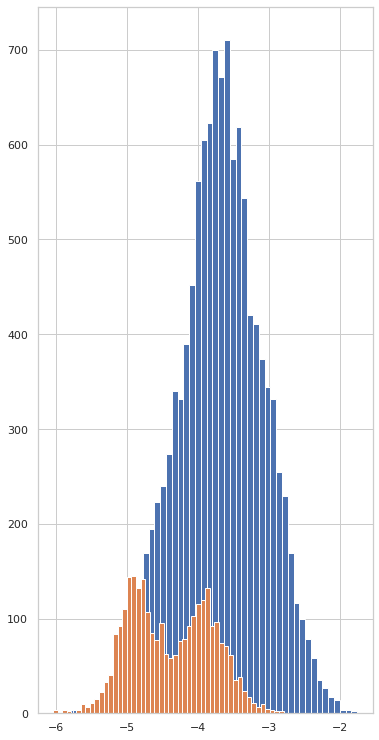

In [194]:
plt.hist(np.log(resE['channel_SREBP'][resE['keep']]), 50)
plt.hist(np.log(resE['channel_SREBP'][np.invert(resE['keep'])]), 50)
None

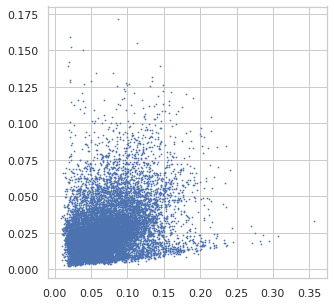

In [195]:
plt.figure(figsize=(5,5))
plt.scatter(resE['channel_NeuN'], resE['channel_SREBP'], s=.5)
#plt.ylim(0,0.1)

In [196]:
def plot_lines(df_temp, x, colors, lognormal, binwidth, comparison, grp, xloc, yloc):
    sns.set(rc={'figure.figsize':(6,13)})
    sns.set_style("whitegrid")

    if lognormal:
        df_temp[x] = np.log(df_temp[x])
        
    f, ax = plt.subplots(3, sharex=True, gridspec_kw={"height_ratios": (1,.5,1)})

    # compute pvalue 
    text0 = compute_nested_anova(df_temp, x, comparison, grp)
    
    sns.histplot(data=df_temp, x=x, ax=ax[0], hue=comparison, binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
    
    ax[0].text(x=xloc, y=yloc, s=text0, fontsize=12, color='black')
    
    sns.boxplot(data=df_temp, x=x, y=comparison,orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    sns.boxplot(data=df_temp, x=x, y=grp,orient="h", ax=ax[2], width=.8, dodge=False, hue = comparison, palette = colors)#, order =(order))#, palette = colors)    
 
    for i in range(3):
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

def compute_nested_anova(resE, score, group, nested_col):
    # Fit a two-level ANOVA model
    model = mixedlm(score + '~' + group, resE, groups=resE[nested_col])
    result = model.fit()

    p = result.pvalues[1]
    
    p_scientific = "{:e}".format(p)

    coef = result.params[1]
    lower = result.conf_int().iloc[1][0]
    upper = result.conf_int().iloc[1][1]
    text0 = 'Coef: ' + str(np.round(coef,3)) + '\n95% CI: [' + str(np.round(lower,3)) + ',' + str(np.round(upper,3)) + '] \n' + 'p: ' + str(p_scientific)
    
    return text0   

In [197]:
colors = dict(zip(np.unique(resE['grp']), ['grey', 'red']))


In [198]:
resE.head()

,channel_SREBP,channel_NeuN,channel_DAPI,ID,file,grp,projid,size,gmm_label,log_DAPI,log_NeuN,keep
0,0.041824,0.093428,0.069044,0,10101327con_1.czi,CON,10101327con,8993.0,0,-2.673017,-2.370560,True
1,0.052477,0.129880,0.060316,0,10101327con_1.czi,CON,10101327con,10690.0,0,-2.808160,-2.041145,True
2,0.023714,0.109429,0.086205,0,10101327con_1.czi,CON,10101327con,1897.0,0,-2.451030,-2.212478,True
3,0.034601,0.124562,0.094686,0,10101327con_1.czi,CON,10101327con,1223.0,0,-2.357194,-2.082956,True
4,0.041843,0.122482,0.144319,0,10101327con_1.czi,CON,10101327con,2451.0,4,-1.935732,-2.099794,True


/state/partition1/slurm_tmp/24579079.0.0/ipykernel_486687/3908047073.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


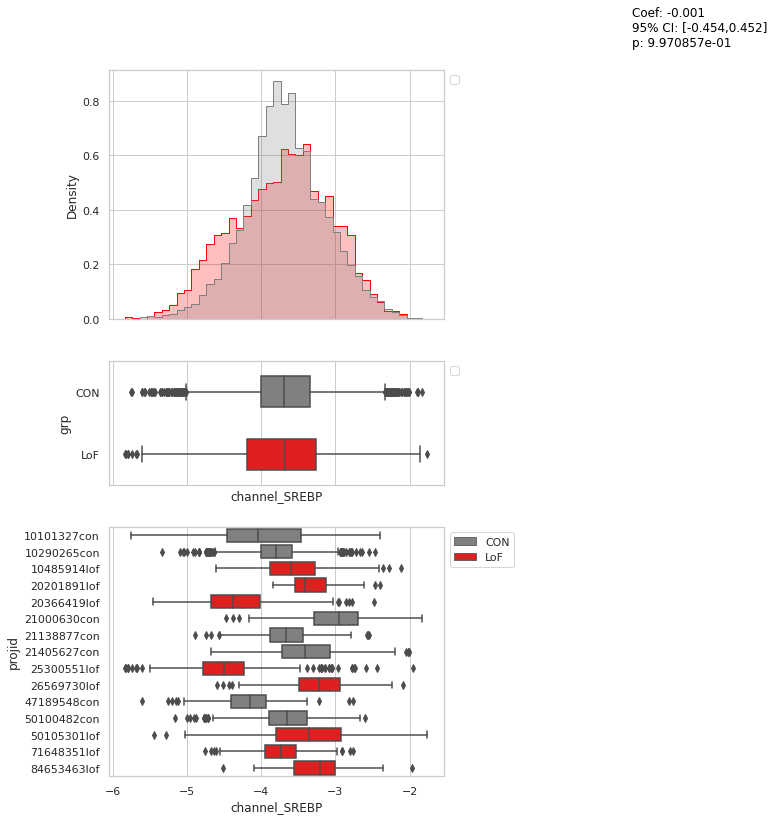

In [199]:
plot_lines(resE[(resE['keep'])], 'channel_SREBP', colors, True, .1, 'grp', 'projid', 1,1)


In [144]:
# plot lines
colors = dict(zip(np.unique(resE['line']), ['grey', 'blue', 'orange']))

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_line.pdf')

KeyError: 'line'

/state/partition1/slurm_tmp/24539183.0.0/ipykernel_958467/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  war

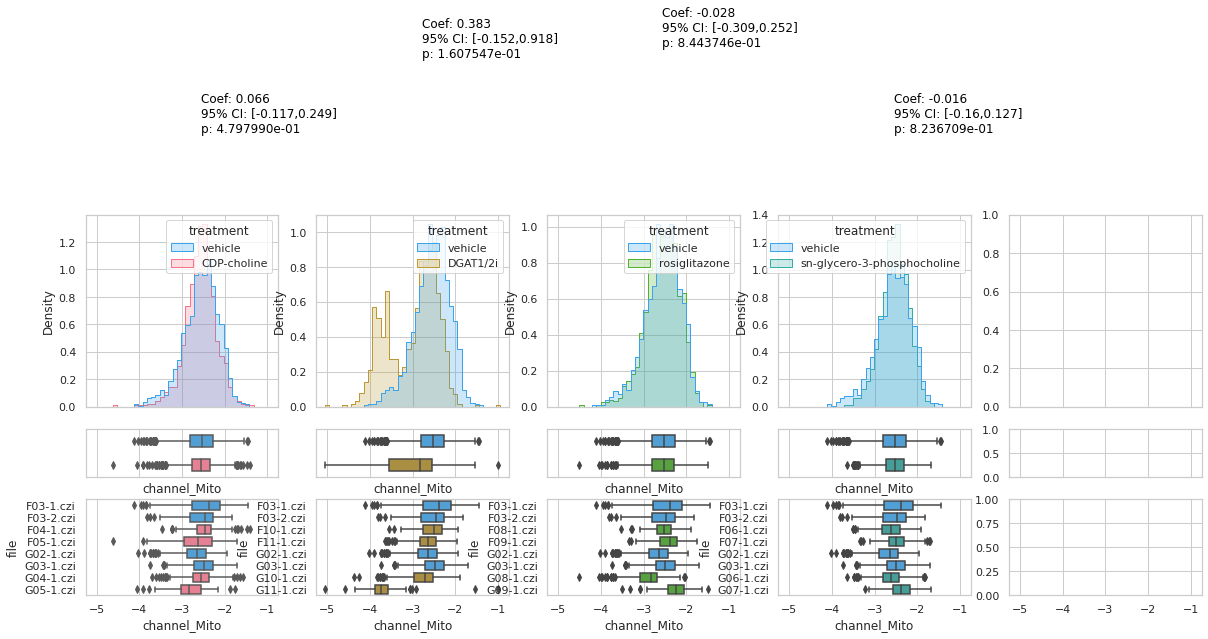

In [50]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Mito', 'G2', colors, True, 0.1, 2, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24539183.0.0/ipykernel_946030/468188541.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


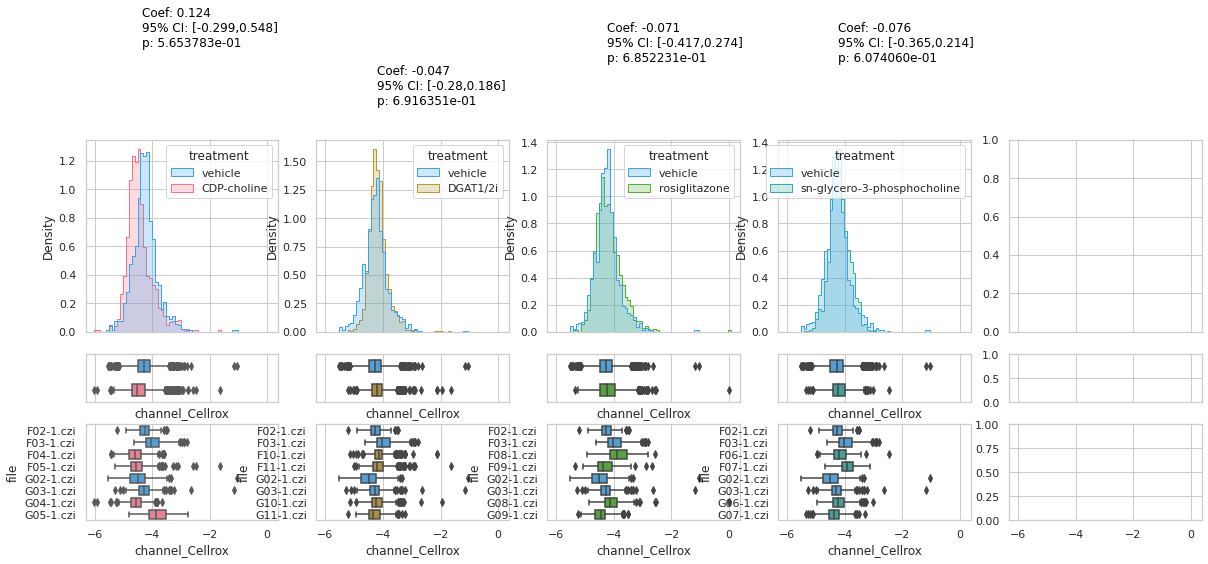

In [97]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Cellrox', 'G2', colors, True, 0.1, 2, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


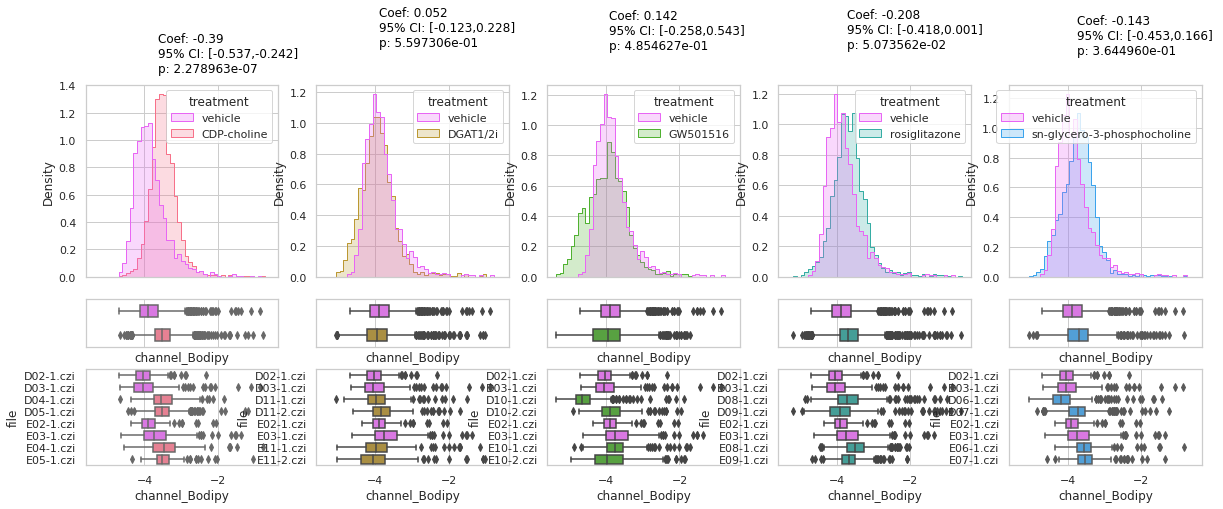

In [93]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Bodipy', 'Y622', colors, True, 0.1, 1.5, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


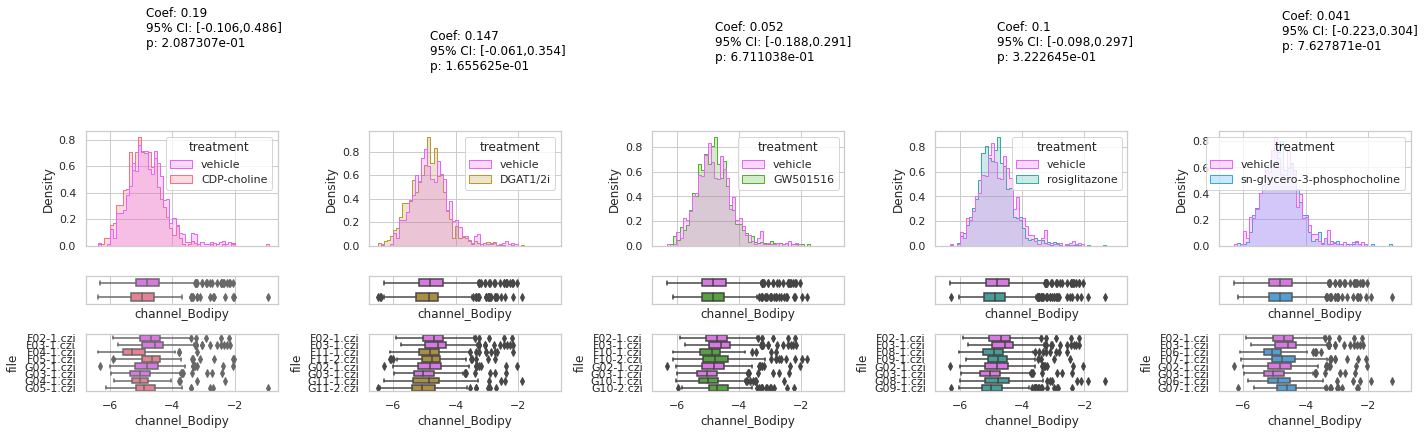

In [102]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resV.loc[resE['keep']], 'channel_Bodipy', 'G2', colors, True, 0.1, 1.5, grp='file')

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_bodipy_resV_G2.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


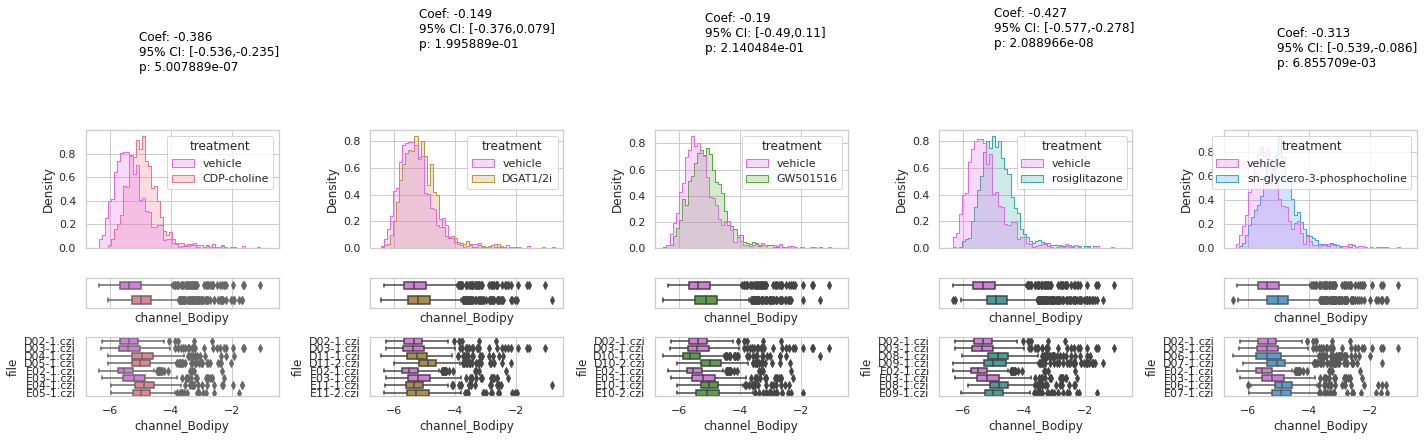

In [103]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resV.loc[resE['keep']], 'channel_Bodipy', 'Y622', colors, True, 0.1, 1.5, grp='file')

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1108_bodipy_resV_Y622.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


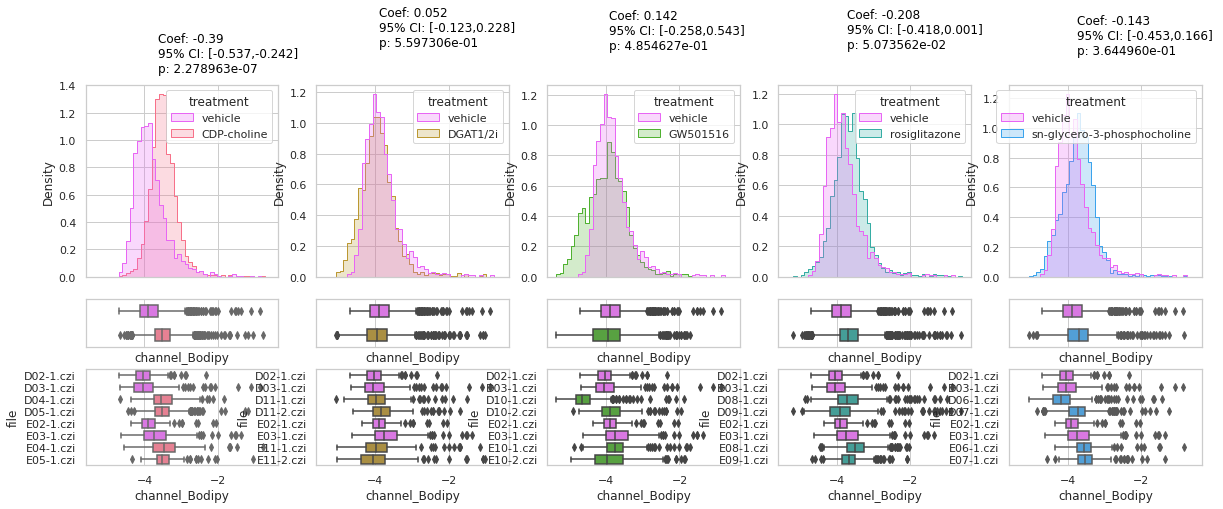

In [96]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Bodipy', 'Y622', colors, True, 0.1, 1.5, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


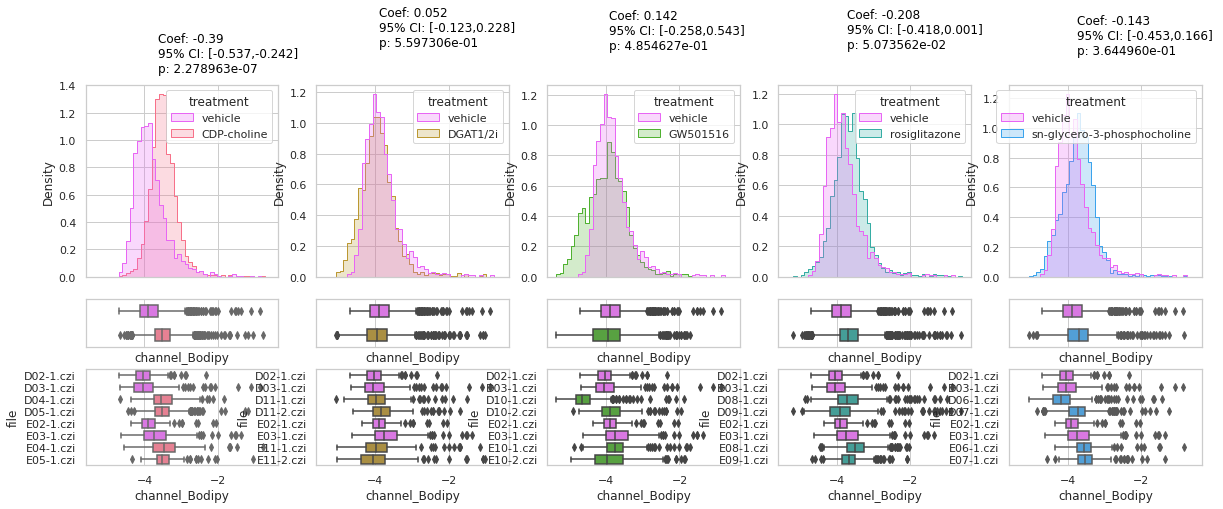

In [77]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Bodipy', 'Y622', colors, True, 0.1, 1.5, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


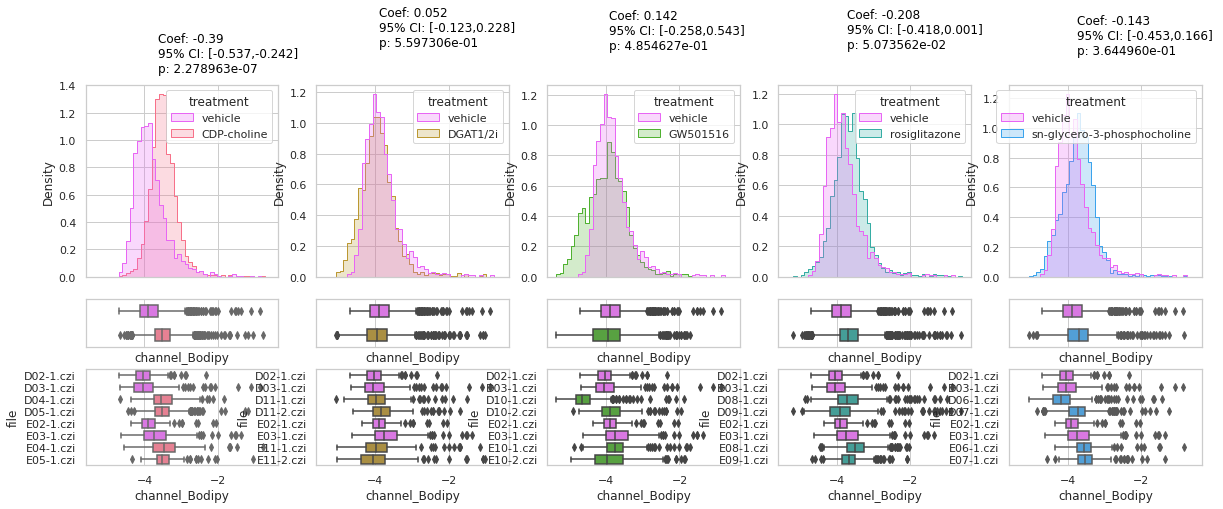

In [71]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Bodipy', 'Y622', colors, True, 0.1, 1.5, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2875603925.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


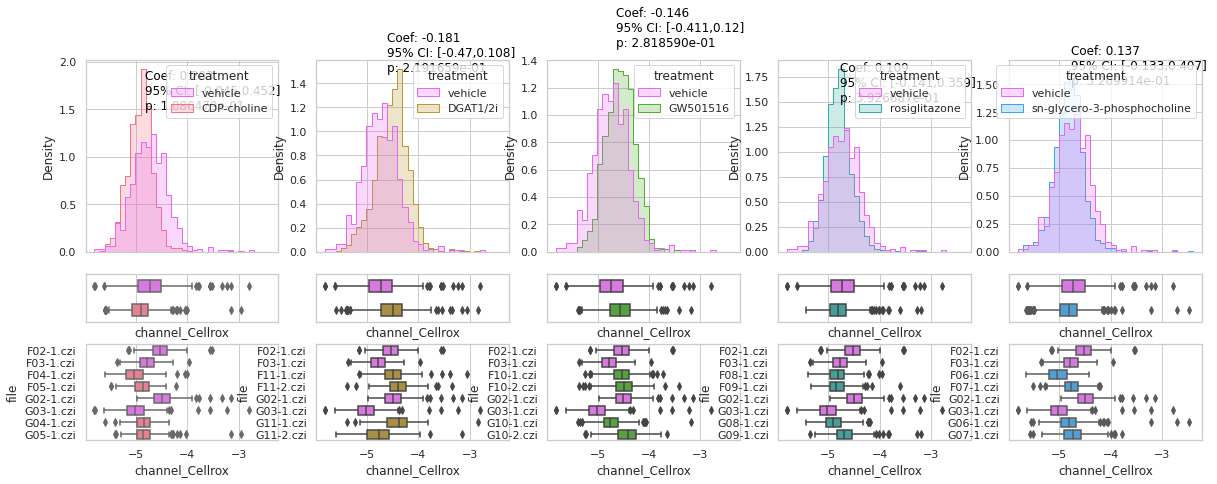

In [70]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Cellrox', 'G2', colors, True, 0.1, 1.5, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/1115_mito_G2_treat.pdf')

/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1118297/1629877405.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

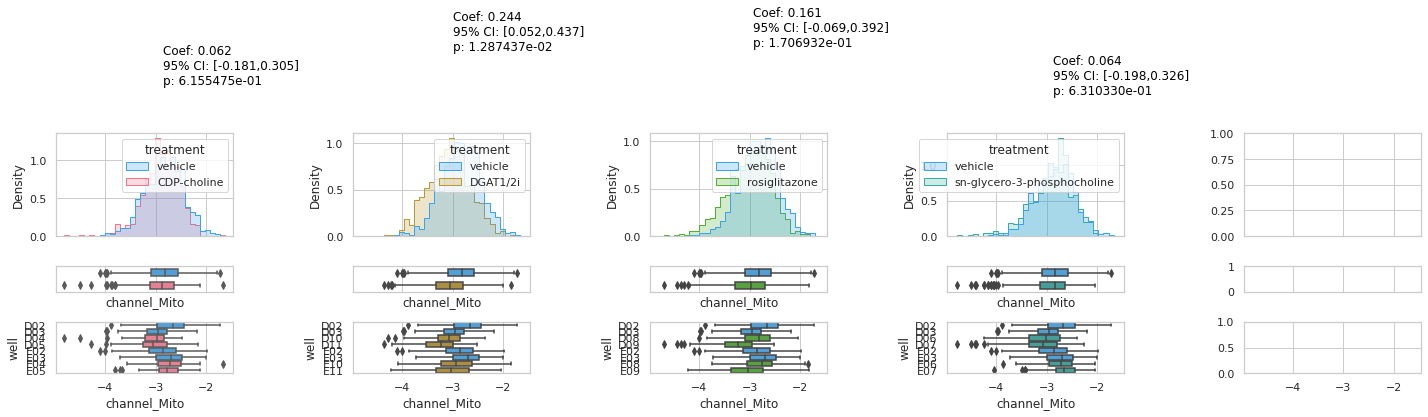

In [88]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE.loc[resE['keep']], 'channel_Mito', 'Y622', colors, True, 0.1, lab_height=2)

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1115_mito_Y622_treat_convergence_fail.pdf')

/state/partition1/slurm_tmp/24523506.0.0/ipykernel_1118297/1629877405.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


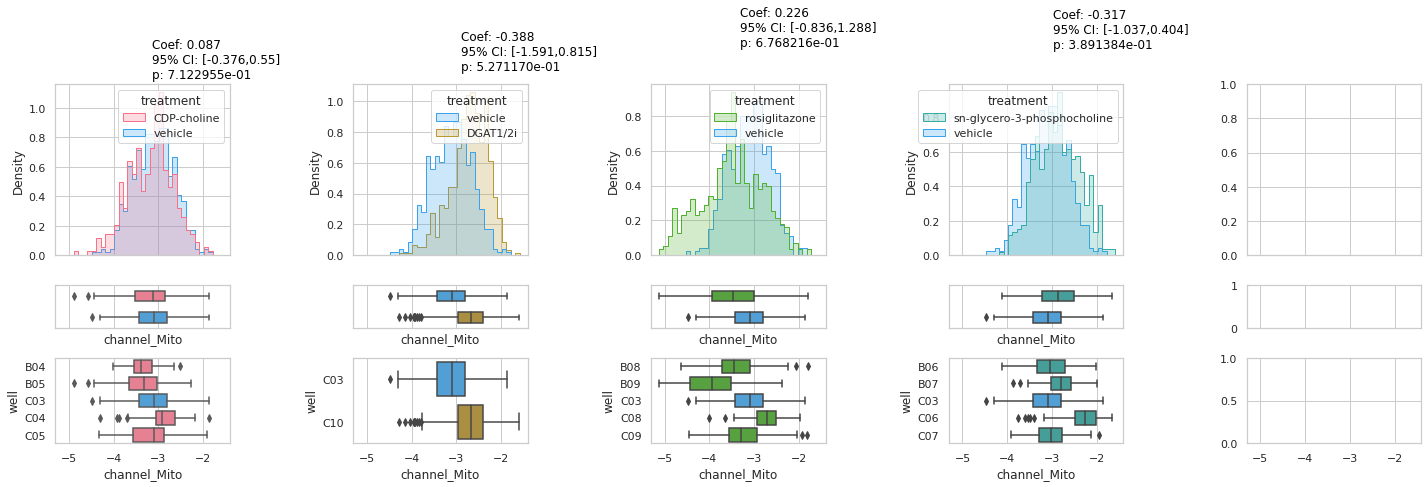

In [65]:
# plot treatments per cell line

set1_colors = sns.color_palette('husl')
colors = dict(zip(np.unique(resE['treatment']), set1_colors[:6]))

plot_treatments(resE[resE['keep']], 'channel_Mito', 'E3', colors, True, 0.1, lab_height=1.2)

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1115_mito_E3_treat.pdf')

In [51]:
resE.to_csv('./outs/neuronbatch11222023_mitohealth_out////resE_1122_mito.csv')
resV.to_csv('./outs/neuronbatch11222023_mitohealth_out/resV_1122__mito.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/state/partition1/slurm_tmp/24526090.0.0/ipykernel_616354/2826489326.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


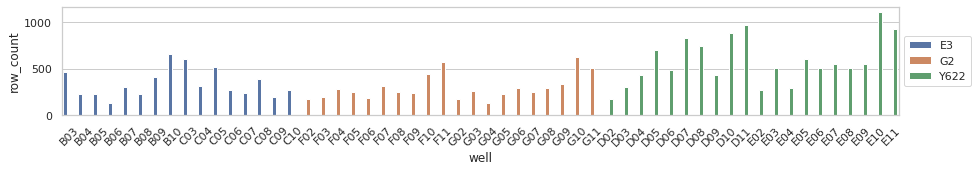

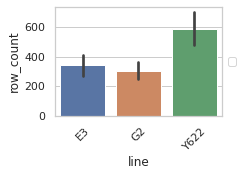

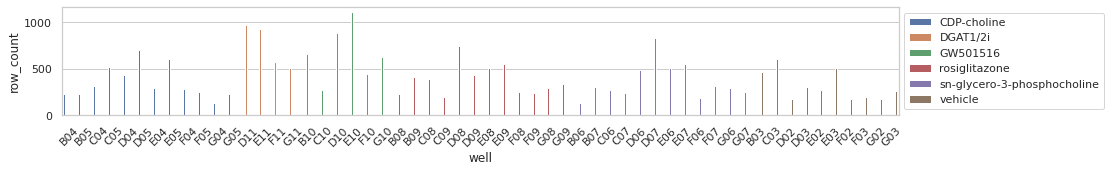

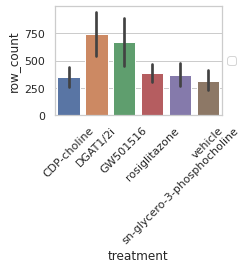

In [105]:
# sanity check cell numbers

row_counts = resE[resE['keep']].groupby(['line', 'well']).size().reset_index(name='row_count')
plt.figure(figsize=(15,2))
sns.barplot(data=row_counts, x='well', y='row_count', hue='line')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(3,2))
sns.barplot(data=row_counts, x='line', y='row_count')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

row_counts = resE[resE['keep']].groupby(['treatment', 'well']).size().reset_index(name='row_count')
plt.figure(figsize=(15,2))
sns.barplot(data=row_counts, x='well', y='row_count', hue='treatment')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.figure(figsize=(3,2))
sns.barplot(data=row_counts, x='treatment', y='row_count')
plt.xticks(rotation=45)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.tight_layout()
plt.savefig('./outs/all_outs/plots/1115_mito_N.pdf')

In [ ]:
#### 

In [32]:
# show rep images

In [3]:
from confocalQuant.segmentation import bgrnd_subtract, gamma_correct_image, extract_channels, impose_segmentation, float_to_int, hide_masks
from confocalQuant.plotting import add_scale_bar, add_inset, plot_axis, get_id_data, get_mean_projections, compute_avs, get_rep_im
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage

In [4]:
resE = pd.read_csv('./outs/neuronbatch11082023_cellrox_bodipy_out/resE_1108_bodipy_cellrox.csv')
# do QC checks - return metadata for which there are image to image differences
parent = './data/neuronbatch11082023_cellrox_bodipy//'
files = get_czi_files(parent)

In [5]:
# toggle segmentations
all_mat, all_masks, Nzi_per_job, cells_per_job, zi_per_job, probs, randID_per_job = return_results('./outs/neuronbatch11082023_cellrox_bodipy_out/run_jobs_110823_cellrox.sbatch', '')

In [6]:
# get rep images
treatments = np.unique(resE['treatment'])
dict_treat = dict(zip(resE['file'], resE['treatment']))
dict_line = dict(zip(resE['file'], resE['line']))

mean_per_filename, mean_per_condition = compute_avs(resE.loc[resE['keep']], 'file', 'treatment', 'line', 'channel_Bodipy')

In [7]:
e3_rep = get_rep_im('vehicle', 'E3', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
y622_rep = get_rep_im('vehicle', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
g2_rep = get_rep_im('vehicle', 'G2', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

In [402]:
# y622_rep2 = get_rep_im('DGAT1/2i', 'Y622', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)
# g2_rep2 = get_rep_im('DGAT1/2i', 'G2', files, mean_per_condition, mean_per_filename, dict_treat, dict_line)

In [8]:
# define column names
collabs = ['NeuN','DAPI',  'NeuN Mask', 'Bodipy']
rowlabs = ['E3', 'Y622', 'G2']

In [9]:
rep = [e3_rep, y622_rep,g2_rep]

In [19]:
# determine upper dict
ma_out = []
mas_out = []

for i in rep:
    mat_sele, mask_sele = get_id_data(i, zi_per_job, Nzi_per_job, all_mat, all_masks)
    ma_out.append(mat_sele)
    mas_out.append(mask_sele)
    
mat_sele = np.vstack(ma_out)
mask_sele = np.vstack(mas_out)

nums = [90, 93, 80,100]
upper_dict = dict(zip(range(4), [np.percentile(mat_sele[:,:,:,x], nums[x]) for x in range(4)]))
lower_dict = {0: 0, 1: 0, 2: 0, 3: 0}
gamma_dict = {0: 1, 1: .7, 2: 1, 3:1}
background_dict = {0: 0, 1: 95, 2: 0,3:0}
percentile=False

In [11]:
from matplotlib.patches import Rectangle

def add_inset(axes, j, i, plt, x1=200,x2=400,y1=400,y2=600):
    axin = axes[j,i].inset_axes([.57, .57, 0.43, 0.43])
    axin.set_xlim(x1, x2)
    axin.set_ylim(y1, y2)
    axin.imshow(plt)
    axes[j,i].indicate_inset_zoom(axin)
    axin.set_xticks([])
    axin.set_yticks([])
    border = Rectangle((0, 0), 5, 5, color='white', linewidth=5, fill=False, transform=axin.transAxes)
    axin.add_patch(border)
    
def add_scale_bar(size, img, plt):
    end = np.round(size/img.physical_pixel_sizes[2])
    for i in range(3):
        plt[50:60,20:(20+int(end)),i] = 1
        
def plot_axis(axes, plt, j, i, size, img, collabs, rowlabs):
    add_scale_bar(size, img, plt)
    axes[j,i].imshow(plt, origin = 'lower')
    axes[j,i].set_xticks([])
    axes[j,i].set_yticks([])
    if j==0:
        axes[j,i].xaxis.set_label_position('top')
        axes[j,i].set_xlabel(collabs[i], fontsize=40)
    if i==0:
        axes[j,i].set_ylabel(rowlabs[j], fontsize=40)

In [15]:
x1=[200,200,200, 200]
x2=[400,400,400,400]
y1=[400,400,400,400]
y2=[600,600,600,600]

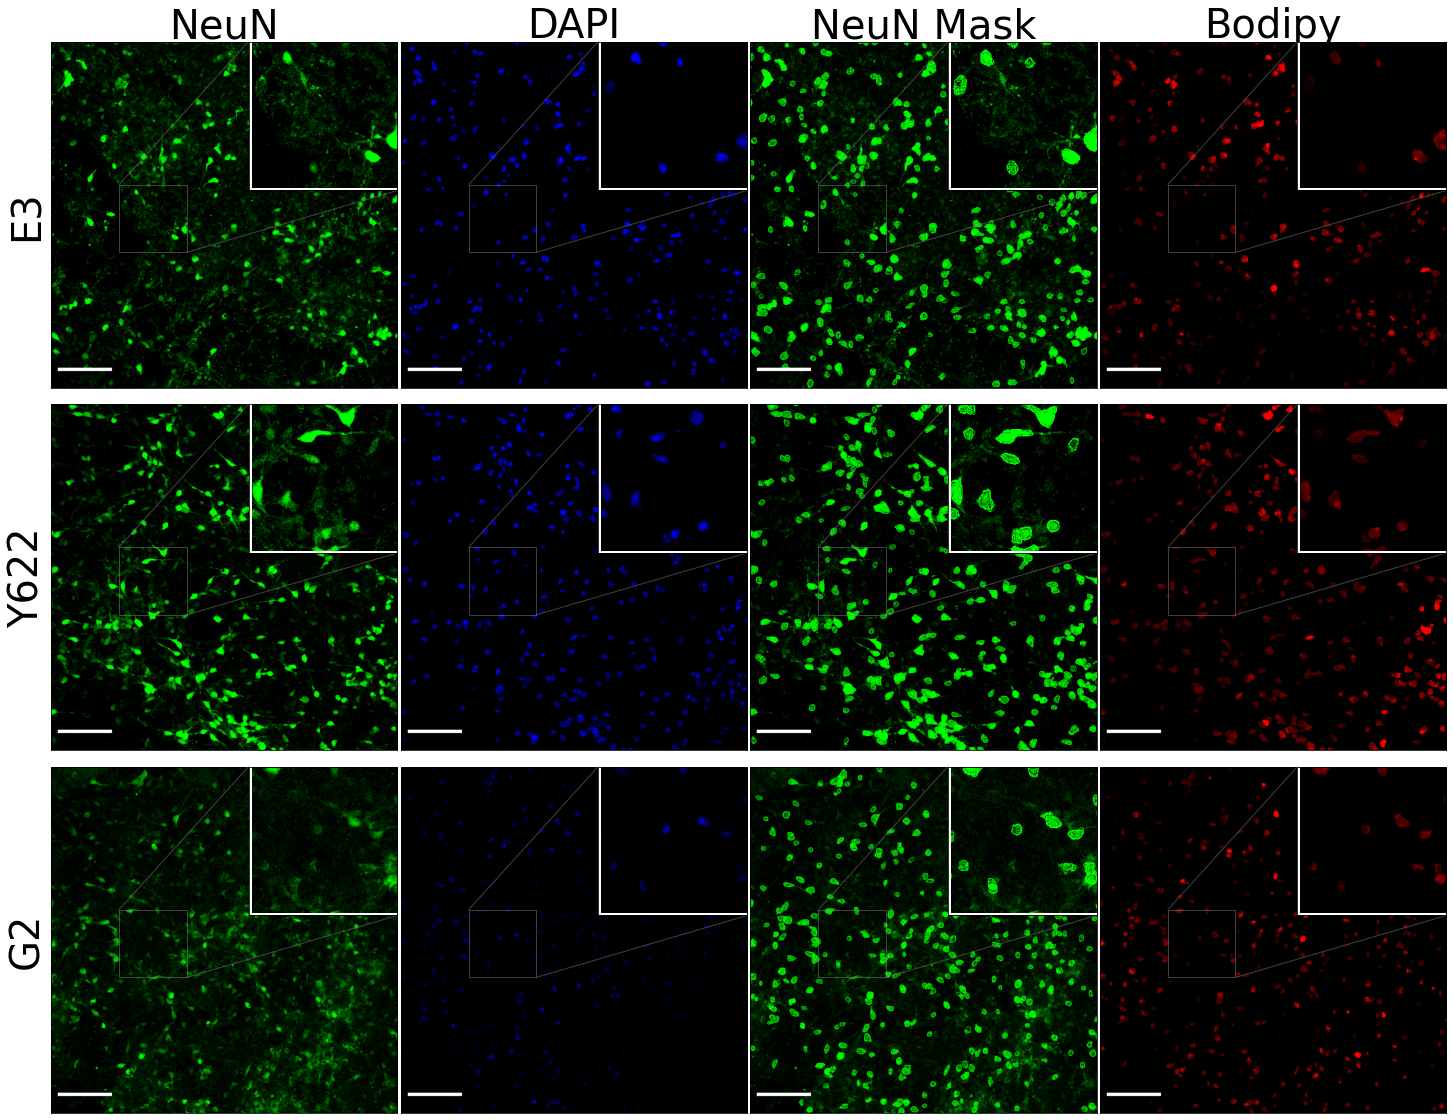

In [20]:
# show images
conditions = rep
fig, axes = plt.subplots(3, 4, figsize=(25, 20))#figsize=(27, 40))
fig.subplots_adjust(hspace=0.001, wspace=0.01)  # Adjust the spacing

for i in range(len(rep)):
    ID = conditions[i]
    mat_sele, mask_sele = get_id_data(ID, zi_per_job, Nzi_per_job, all_mat, all_masks)
    
    # make plots
    plt0 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[0], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)
    plt1 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[2], order=[2,1,0], mask_channel = [2], maskit=True, percentile=percentile)
    d = impose_segmentation(mask_sele, mat_sele, val=1)
    plt2 = get_mean_projections(d, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)
    plt3 = get_mean_projections(mat_sele, mask_sele, background_dict=background_dict, gamma_dict=gamma_dict, lower_dict=lower_dict, upper_dict=upper_dict, channels=[1], order=[2,1,0], mask_channel = [0], maskit=True, percentile=percentile)

    # get image
    imgA = AICSImage(parent + files[ID])

    # show plots
    plot_axis(axes, plt3, i,0, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,0, plt3,x1=x1[i],x2=x2[i],y1=y1[i],y2=y2[i])

    plot_axis(axes, plt0, i,1, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,1, plt0,x1=x1[i],x2=x2[i],y1=y1[i],y2=y2[i])
    
    plot_axis(axes, plt2, i,2, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,2, plt2,x1=x1[i],x2=x2[i],y1=y1[i],y2=y2[i])

    plot_axis(axes, plt1, i,3, 100, imgA, collabs, rowlabs)
    add_inset(axes, i,3, plt1,x1=x1[i],x2=x2[i],y1=y1[i],y2=y2[i])
    


#fig.savefig('./outs/all_outs/plots/1108_mito_resE_treat_DGAT_rep.png')


In [ ]:
# have to modify stats to be per file (ie include image & well)
# have to modify batch-combined stats to include batch (image, well, batch)

In [487]:
#### plotting across batches
resE22 = pd.read_csv('./outs/neuronbatch11222023_mitohealth_out/resE_1122_mito.csv')
resE15 = pd.read_csv('./outs/neuronbatch11152023_mitohealth_out/resE_1115mito.csv')
resE08 = pd.read_csv('./outs/neuronbatch11082023_mitohealth_out/resE_1108mito.csv')
resE22['batch'] = 22
resE15['batch'] = 15
resE08['batch'] = 8

temp = pd.concat((resE22, resE15,resE08))#, resE22))

temp.index = range(temp.shape[0])
temp['file'] = [temp['file'][x]+'_'+str(temp['batch'][x]) for x in range(len(temp['file']))]

In [441]:
resE22 = pd.read_csv('./outs/neuronbatch11082023_cellrox_bodipy_out/resE_1108_bodipy_cellrox.csv')
resE15 = pd.read_csv('./outs/neuronbatch11222023_cellrox_out/resE_1122_4HNE_cellrox.csv')
#resE08 = pd.read_csv('./outs/neuronbatch11082023_mitohealth_out/resE_1108mito.csv')


In [488]:
df_no_duplicates = temp.drop_duplicates(subset='file')


In [491]:
row_counts = temp.groupby(['line', 'treatment']).size().reset_index(name='row_count')


In [492]:
row_counts

,line,treatment,row_count
0,E3,CDP-choline,2659
1,E3,DGAT1/2i,3840
2,E3,GW501516,1104
3,E3,rosiglitazone,3141
4,E3,sn-glycero-3-phosphocholine,2873
5,E3,vehicle,3238
6,G2,CDP-choline,3958
7,G2,DGAT1/2i,4217
8,G2,GW501516,985
9,G2,rosiglitazone,3841


In [285]:
def plot_treatments(df, x, line, colors, lognormal, binwidth,lab_height, nested_col, text_x, text_y, size, grp='well'):
    sns.set(rc={'figure.figsize':(20,3)})
    sns.set_style("whitegrid")
    df_temp = df[df['line']==line]
    


    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(2,5, sharex=True, gridspec_kw={"height_ratios": (1,.5)})

    for i,t in enumerate(np.unique(df['treatment'])[:-1]):
        index = (df_temp['treatment']=='vehicle') | (df_temp['treatment']==t)
        # compute pvalue 
        text = compute_nested_anova(df_temp[index], x, 'treatment', nested_col)
        sns.histplot(data=df_temp[index], x=x, ax=ax[0,i], hue='treatment', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
        
        ax[0,i].text(x=text_x, y=text_y, s=text, fontsize=size, color='black')
        ax[0,i].set_title(t)
        #ax[0,i].legend(loc='lower left', bbox_to_anchor=(0, 1))
        sns.boxplot(data=df_temp[index], x=x, y='treatment',orient="h", ax=ax[1,i], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
        #sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[2,i], width=.8, dodge=False, hue = 'treatment', palette = colors)#, order =(order))#, palette = colors)
        ax[0,i].get_legend().remove()
        ax[1,i].axes.get_yaxis().set_visible(False)




def plot_lines(df, x, treatment, colors, lognormal, binwidth, nested_col, text_x, text_y, size, grp='well'):
    sns.set(rc={'figure.figsize':(4,5)})
    sns.set_style("whitegrid")
    df_temp = df[df['treatment']==treatment]

    if lognormal:
        df_temp[x] = np.log(df_temp[x])
        
    f, ax = plt.subplots(4, sharex=True, gridspec_kw={"height_ratios": (1,.5,1,.5)})

    index = df_temp['line']!='G2'
    # compute pvalue 
    text0 = compute_nested_anova(df_temp[index], x, 'line', grp)
    
    sns.histplot(data=df_temp[index], x=x, ax=ax[0], hue='line', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
    
    ax[0].text(x=text_x, y=text_y, s=text0, fontsize=size, color='black')
    
    sns.boxplot(data=df_temp[index], x=x, y='line',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    #sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[2], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)

    index = df_temp['line']!='Y622'
    
    # compute pvalue 
    text1 = compute_nested_anova(df_temp[index], x, 'line', nested_col)
    
    sns.histplot(data=df_temp[index], x=x, ax=ax[2], hue='line', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
    
    ax[2].text(x=text_x, y=text_y, s=text1, fontsize=size, color='black')

    sns.boxplot(data=df_temp[index], x=x, y='line',orient="h", ax=ax[3], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
    #sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[5], width=.8, dodge=False, hue = 'line', palette = colors)#, order =(order))#, palette = colors)
    
    for i in range(4):
        ax[i].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm

def compute_nested_anova(resE, score, group, nested_col):
    # Fit a two-level ANOVA model
    model = mixedlm(score + '~' + group, resE, groups=resE[nested_col])
    result = model.fit()

    p = result.pvalues[1]
    
    p_scientific = "{:e}".format(p)

    coef = result.params[1]
    lower = result.conf_int().iloc[1][0]
    upper = result.conf_int().iloc[1][1]
    text0 = 'Coef: ' + str(np.round(coef,3)) + '\n95% CI: [' + str(np.round(lower,3)) + ',' + str(np.round(upper,3)) + '] \n' + 'p: ' + str(p_scientific)
    
    return text0   

def plot_treatments2(df, x, line, colors, lognormal, binwidth,lab_height, nested_col, text_x, text_y, size, grp='well'):
    sns.set(rc={'figure.figsize':(8,4)})
    sns.set_style("whitegrid")
    df_temp = df[df['line']==line]
    


    if lognormal:
        df_temp[x] = np.log(df_temp[x])
    
    f, ax = plt.subplots(2,1, sharex=True, gridspec_kw={"height_ratios": (1,.5)})

    #for i,t in enumerate(np.unique(df['treatment'])[:-1]):
        # compute pvalue 
    #text = compute_nested_anova(df_temp, x, 'treatment', nested_col)
    sns.histplot(data=df_temp, x=x, ax=ax[0], hue='treatment', binwidth=binwidth, element="step", common_norm=False, stat='density', palette = colors)
        
    #ax[0].text(x=text_x, y=text_y, s=text, fontsize=size, color='black')
    #ax[0].set_title(t)
        #ax[0,i].legend(loc='lower left', bbox_to_anchor=(0, 1))
    sns.boxplot(data=df_temp, x=x, y='treatment',orient="h", ax=ax[1], width=.5, dodge=True, palette = colors)#, order =(order))#, palette = colors)
        #sns.boxplot(data=df_temp[index], x=x, y=grp,orient="h", ax=ax[2,i], width=.8, dodge=False, hue = 'treatment', palette = colors)#, order =(order))#, palette = colors)
    #ax[0].get_legend().remove()
    ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    #ax[1].axes.get_yaxis().set_visible(False)


In [442]:

resE22['batch'] = 22
resE15['batch'] = 15
#resE08['batch'] = 8

# scale vals per batch
resE22['channel_Cellrox'] = (resE22['channel_Cellrox']-np.mean(resE22['channel_Cellrox']))/np.std(resE22['channel_Cellrox'])
resE15['channel_Cellrox'] = (resE15['channel_Cellrox']-np.mean(resE15['channel_Cellrox']))/np.std(resE15['channel_Cellrox'])
#resE08['channel_Mito'] = (resE08['channel_Mito']-np.mean(resE08['channel_Mito']))/np.std(resE08['channel_Mito'])

temp = pd.concat((resE22, resE15))#, resE22))

temp.index = range(temp.shape[0])
temp['file'] = [temp['file'][x]+'_'+str(temp['batch'][x]) for x in range(len(temp['file']))]
temp['well'] = [temp['well'][x]+'_'+str(temp['batch'][x]) for x in range(len(temp['well']))]

temp.index = range(temp.shape[0])
temp = temp[temp['keep']]
temp['channel_Cellrox']=temp['channel_Cellrox']-np.min(temp['channel_Cellrox'])
temp = temp.iloc[np.array(np.argsort(temp['line']))]

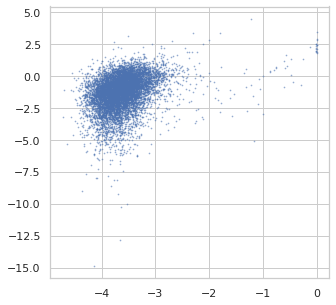

In [454]:
plt.figure(figsize=(5,5))
plt.scatter(np.log(resE15['channel_4HNE']), np.log(resE15['channel_Cellrox']),s=.5, alpha=.5)

In [457]:
resE15.head()b


,Unnamed: 0,channel_DAPI,channel_NeuN,channel_4HNE,channel_Cellrox,ID,file,line,treatment,well,size,gmm_label,log_DAPI,log_NeuN,keep,batch
0,0,0.032974,0.113835,0.023146,-0.269128,0,B03-1.czi,E3,vehicle,B03,2429.0,4,-3.412039,-2.173004,True,15
1,1,0.022430,0.172155,0.023776,0.227137,0,B03-1.czi,E3,vehicle,B03,996.0,4,-3.797372,-1.759362,True,15
2,2,0.010924,0.174022,0.018041,-0.650320,0,B03-1.czi,E3,vehicle,B03,2951.0,4,-4.516801,-1.748576,True,15
3,3,0.056654,0.096464,0.024602,-0.159039,0,B03-1.czi,E3,vehicle,B03,2157.0,2,-2.870799,-2.338588,True,15
4,4,0.058312,0.059222,0.016061,-0.661143,0,B03-1.czi,E3,vehicle,B03,1890.0,2,-2.841940,-2.826465,True,15


,Unnamed: 0,channel_DAPI,channel_NeuN,channel_4HNE,channel_Cellrox,ID,file,line,treatment,well,size,gmm_label,log_DAPI,log_NeuN,keep,batch
1,1,0.022430,0.172155,0.023776,0.227137,0,B03-1.czi,E3,vehicle,B03,996.0,4,-3.797372,-1.759362,True,15
17,17,0.009095,0.126139,0.028411,0.631140,0,B03-1.czi,E3,vehicle,B03,407.0,1,-4.700059,-2.070375,False,15
20,20,0.045750,0.107086,0.030372,0.478812,0,B03-1.czi,E3,vehicle,B03,2698.0,2,-3.084554,-2.234124,True,15
23,23,0.051473,0.078616,0.031907,0.390558,0,B03-1.czi,E3,vehicle,B03,691.0,2,-2.966692,-2.543182,True,15
30,30,0.063766,0.051129,0.030442,0.325456,0,B03-1.czi,E3,vehicle,B03,895.0,2,-2.752535,-2.973402,True,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22629,22629,0.027354,0.062714,0.034633,0.115465,59,G11-1.czi,G2,DGAT1/2i,G11,991.0,4,-3.598908,-2.769165,True,15
22631,22631,0.019829,0.095819,0.025483,0.632294,59,G11-1.czi,G2,DGAT1/2i,G11,739.0,4,-3.920612,-2.345296,True,15
22635,22635,0.003559,0.136552,0.015036,0.409919,59,G11-1.czi,G2,DGAT1/2i,G11,329.0,1,-5.638383,-1.991048,False,15
22636,22636,0.019388,0.103654,0.018845,0.188720,59,G11-1.czi,G2,DGAT1/2i,G11,532.0,4,-3.943095,-2.266695,True,15


In [463]:
resE15.loc[resE15['channel_Cellrox']>np.mean(resE15['channel_Cellrox'])].shape

(8347, 16)

/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is 

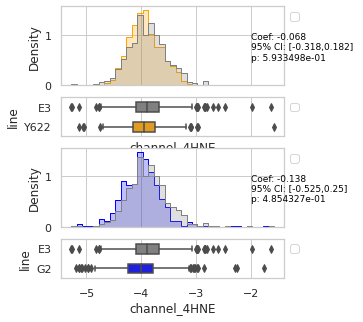

In [464]:
# plot lines
#temp = resE22[resE22['keep']]
colors = dict(zip(np.unique(resE15['line']), ['grey', 'blue', 'orange']))
plot_lines(resE15.loc[resE15['channel_Cellrox']<np.mean(resE15['channel_Cellrox'])], 'channel_4HNE', 'vehicle', colors, True, .1,  nested_col='file', text_x = -2, text_y=.5, size=9, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/bodipy_1108.pdf')

In [426]:
np.un

(23255, 15)

/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is 

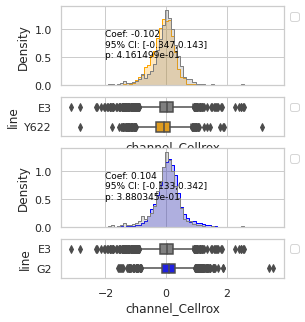

In [444]:
# plot lines
#temp = resE22[resE22['keep']]
colors = dict(zip(np.unique(temp['line']), ['grey', 'blue', 'orange']))
plot_lines(temp, 'channel_Cellrox', 'vehicle', colors, True, .1,  nested_col='file', text_x = -2, text_y=.5, size=9, grp='file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/bodipy_1108.pdf')

/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is 

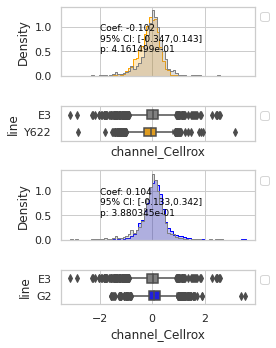

In [445]:
# plot lines
colors = dict(zip(np.unique(temp['line']), ['grey', 'blue', 'orange']))
plot_lines(temp, 'channel_Cellrox', 'vehicle', colors, True, .1,  nested_col='file', text_x = -2, text_y=.5, size=9, grp='file')

plt.tight_layout()
#plt.savefig('./outs/all_outs/plots/mitohealth_all_batch.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:508: RuntimeWarning: invalid value encountered in subtract
  return rhs / s - ql / s**2
/home/gridsan/djuna/.local/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization fai

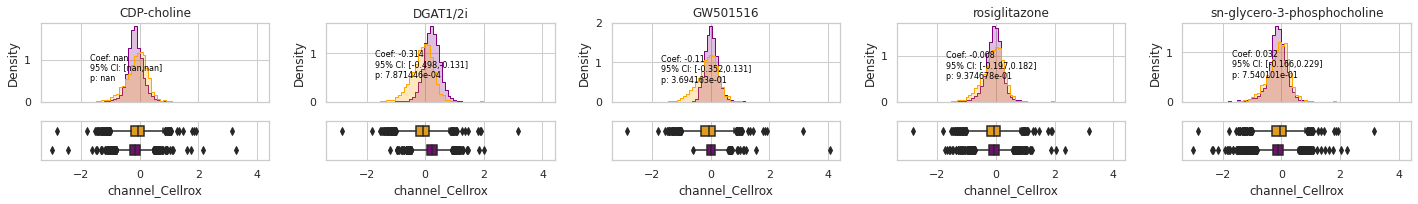

In [446]:
colors = dict(zip(np.unique(temp['treatment']), ['purple', 'purple',  'purple', 'purple', 'purple', 'orange']))
temp2 = temp.iloc[np.array(np.argsort(temp['treatment'])[::-1])]
plot_treatments(temp2, 'channel_Cellrox', 'Y622', colors, True, 0.1, 1.5,  'file',-1.7, .5, 8, 'file')

plt.tight_layout()
#plt.savefig('./outs/all_outs/plots/mitohealth_all_batch_y622.pdf')

/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])


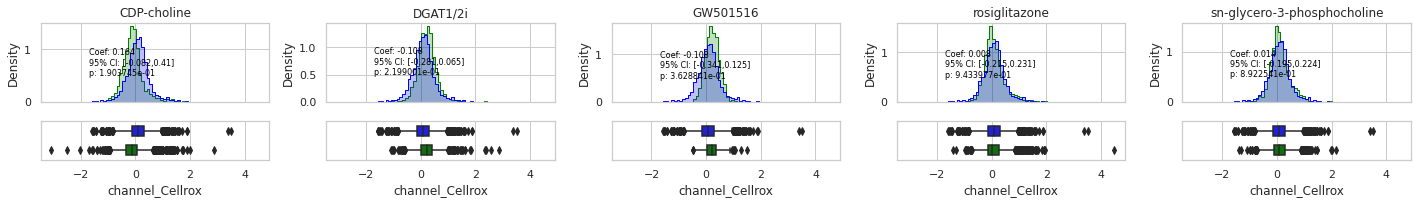

In [447]:
colors = dict(zip(np.unique(temp['treatment']), ['green', 'green',  'green', 'green', 'green', 'blue']))
temp2 = temp.iloc[np.array(np.argsort(temp['treatment'])[::-1])]
plot_treatments(temp2, 'channel_Cellrox', 'G2', colors, True, 0.1, 1.5,  'file',-1.7, .5, 8, 'file')
plt.tight_layout()
#plt.savefig('./outs/all_outs/plots/mitohealth_all_batch_G2.pdf')

/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


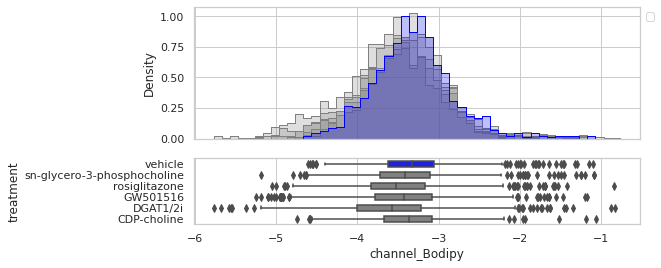

In [421]:
set1_colors = sns.color_palette('husl')

#colors = dict(zip(np.unique(temp['treatment']), set1_colors[:6]))
colors = dict(zip(np.unique(temp['treatment']), ['grey', 'grey',  'grey', 'grey', 'grey', 'blue']))

temp2 = temp.iloc[np.array(np.argsort(temp['treatment'])[::-1])]
plot_treatments2(temp2, 'channel_Bodipy', 'G2', colors, True, 0.1, 1.5,  'file',-1.7, .5, 8, 'file')

# plt.tight_layout()
# plt.savefig('./outs/all_outs/plots/mitohealth_all_batch_y622_all_treat.pdf')

/home/gridsan/djuna/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


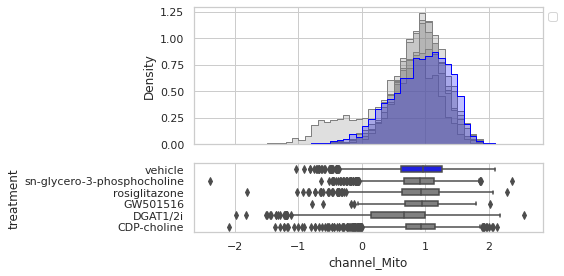

In [287]:
set1_colors = sns.color_palette('husl')

#colors = dict(zip(np.unique(temp['treatment']), set1_colors[:6]))
colors = dict(zip(np.unique(temp['treatment']), ['grey', 'grey',  'grey', 'grey', 'grey', 'blue']))

temp2 = temp.iloc[np.array(np.argsort(temp['treatment'])[::-1])]
plot_treatments2(temp2, 'channel_Mito', 'G2', colors, True, 0.1, 1.5,  'file',-1.7, .5, 8, 'file')

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/mitohealth_all_batch_g2_all_treat.pdf')

/state/partition1/slurm_tmp/24551690.0.0/ipykernel_744060/785774052.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp[x] = np.log(df_temp[x])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


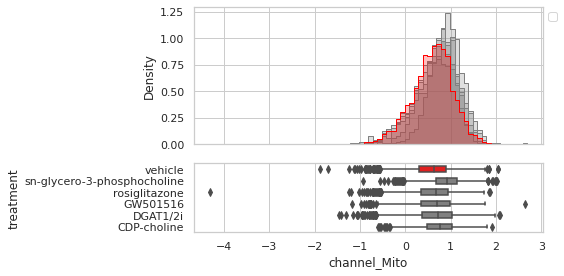

In [288]:
set1_colors = sns.color_palette('husl')

#colors = dict(zip(np.unique(temp['treatment']), set1_colors[:6]))
colors = dict(zip(np.unique(temp['treatment']), ['grey', 'grey',  'grey', 'grey', 'grey', 'red']))

temp2 = temp.iloc[np.array(np.argsort(temp['treatment'])[::-1])]
plot_treatments2(temp2, 'channel_Mito', 'E3', colors, True, 0.1, 1.5,  'file',-1.7, .5, 8, 'file')

plt.tight_layout()
plt.savefig('./outs/all_outs/plots/mitohealth_all_batch_e3_all_treat.pdf')

In [ ]:
# size filter?